# 가상환경에서 진행예정.

env_name = detectron2_py3.8 <br/>
---
- version : <br/>
    - torch 1.8 <br/>
    - cuda 10.2 <br/>
    - python 3.8.16 <br/>

## index
0 = person ------------------------<br/>
1 = bicycle ----------------------------<br/>
2 = car ----------------------------<br/>
3 = motorcycle ----------------------<br/>
~~4 = airplane~~<br/>
5 = bus --------------------------------<br/>
~~6 = train ~~<br/>
7 = truck --------------------------------<br/>

# IMAGE

In [12]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import torch
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt
from collections import deque
import multiprocessing as mp
import atexit
import bisect
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
import time

import predictor
from demo import VisualizationDemo

In [13]:
from detectron2.structures import Boxes

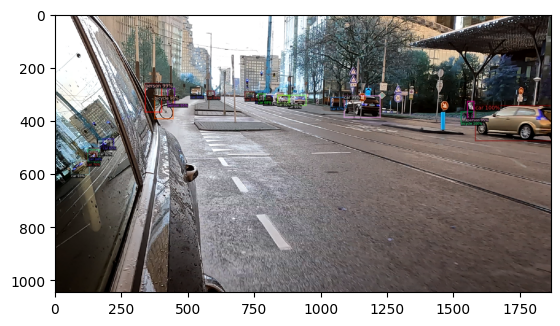

In [14]:
input_image_path = '/home/sldev1/github/data/test1.png'

oim = cv2.imread(input_image_path)
#print('original image')
#cv2_imshow(im)
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.65  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
#cfg.MODEL.DEVICE = 'cpu' #changing to cpu
predictor = DefaultPredictor(cfg)

## Function for detecting and segmenting only 1 class i.e cups
def onlykeep_person_class(outputs):
    cls = outputs['instances'].pred_classes
    scores = outputs["instances"].scores
    boxes = outputs['instances'].pred_boxes

  # index to keep whose class == 0
        # index chart
        # 0 = person -------------------------<br/>
        # 1 = bicycle ------------------------<br/>
        # 2 = car ----------------------------<br/>
        # 3 = motorcycle ---------------------<br/>
        # 4 = airplane
        # 5 = bus -----------------------------<br/>
        # 6 = train
        # 7 = truck ---------------------------<br/>
        
    a = (cls == 0).nonzero().flatten().tolist()
    b = (cls == 1).nonzero().flatten().tolist()
    c = (cls == 2).nonzero().flatten().tolist()
    d = (cls == 3).nonzero().flatten().tolist()
    e = (cls == 5).nonzero().flatten().tolist()
    f = (cls == 7).nonzero().flatten().tolist()

    a.extend(b)
    a.extend(c)
    a.extend(d)
    a.extend(e)
    a.extend(f)
    
    a.sort()

    indx_to_keep = a
    
  # only keeping index  corresponding arrays
    cls1 = torch.tensor(np.take(cls.cpu().numpy(), indx_to_keep))
    scores1 = torch.tensor(np.take(scores.cpu().numpy(), indx_to_keep))
    boxes1 = Boxes(torch.tensor(np.take(boxes.tensor.cpu().numpy(), indx_to_keep, axis=0)))
  
  # create new instance obj and set its fields
    obj = detectron2.structures.Instances(image_size=(oim.shape[0], oim.shape[1]))
    obj.set('pred_classes', cls1)
    obj.set('scores', scores1)
    obj.set('pred_boxes',boxes1)
    
    return obj

### predictions and only cup detection display
original_outputs = predictor(oim) #30 seconds(CPU) #1 seconds(GPU)
modified_outputs = onlykeep_person_class(original_outputs)


v = Visualizer(oim[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(modified_outputs.to("cpu"))
cv2.imwrite(input_image_path.replace(".","_only_6classes_detected."),out.get_image()[:, :, ::-1])
plt.imshow(out.get_image()[:, :, ::-1])

In [78]:
  # index to keep whose class == 0
        # index chart
        # 0 = person -------------------------<br/>
        # 1 = bicycle ------------------------<br/>
        # 2 = car ----------------------------<br/>
        # 3 = motorcycle ---------------------<br/>
        # 4 = airplane
        # 5 = bus -----------------------------<br/>
        # 6 = train
        # 7 = truck ---------------------------<br/>

person_count = (original_outputs['instances'].pred_classes).tolist().count(0)
bicycle_count = (original_outputs['instances'].pred_classes).tolist().count(1)
car_count = (original_outputs['instances'].pred_classes).tolist().count(2)
motorcycle_count = (original_outputs['instances'].pred_classes).tolist().count(3)
bus_count = (original_outputs['instances'].pred_classes).tolist().count(5)
truck_count = (original_outputs['instances'].pred_classes).tolist().count(7)

print(f" person : {person_count} \n bicycle : {bicycle_count} \n car : {car_count} \n motorcycle_count : {motorcycle_count} \n bus : {bus_count} \n truck : {truck_count}")

 person : 3 
 bicycle : 2 
 car : 17 
 motorcycle_count : 0 
 bus : 0 
 truck : 0


In [62]:
a = (original_outputs['instances'].pred_classes == 0).nonzero().flatten().tolist().

# b = (original_outputs['instances'].pred_classes == 1).nonzero().flatten().tolist()
# c = (original_outputs['instances'].pred_classes == 2).nonzero().flatten().tolist()
# d = (original_outputs['instances'].pred_classes == 3).nonzero().flatten().tolist()
# e = (original_outputs['instances'].pred_classes == 5).nonzero().flatten().tolist()
# f = (original_outputs['instances'].pred_classes == 7).nonzero().flatten().tolist()

# a.extend(b)
# a.extend(c)
# a.extend(d)
# a.extend(e)
# a.extend(f)

# a.sort()
a

[2, 6, 7]

# 뜯어보는 중

In [17]:
# 0 1 2 3 5 7

# cls == 0
x = original_outputs['instances'].pred_classes
wanted_x = onlykeep_person_class(x)

print(wanted_x, "\n\n")


a = (x == 0).nonzero().flatten().tolist()
b = (x == 1).nonzero().flatten().tolist()
c = (x == 2).nonzero().flatten().tolist()
d = (x == 3).nonzero().flatten().tolist()
e = (x == 5).nonzero().flatten().tolist()
f = (x == 7).nonzero().flatten().tolist()
a.extend(b)
a.extend(c)
a.extend(d)
a.extend(e)
a.extend(f)
a.sort()


print(a,"\n\n", b,"\n\n",c, "\n\n")


(x == 0).nonzero().flatten().tolist()

IndexError: too many indices for tensor of dimension 1

# VIDEO
참고사이트
https://stackoverflow.com/questions/60663073/how-can-i-properly-run-detectron2-on-videos

In [1]:
#!/usr/bin/env python3
# -- coding: utf-8 --

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# import some common libraries
import torch
import numpy as np
import tqdm
import cv2
import glob
import re
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import Boxes
import time

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-eqfp_5zc because the default path (/home/sldev1/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
path = "/home/sldev1/Project/hyeongeun_test/data/AR_CMS_DATASET/221124/RH/"

def videoPath(path):
    video_path = glob.glob(path+'*.MP4')

    return video_path

video_list = videoPath(path)

In [3]:
def runOnVideo(video, maxFrames):
    """ Runs the predictor on every frame in the video (unless maxFrames is given),
    and returns the frame with the predictions drawn.
    """
    def onlykeep_wanted_class(outputs):
        cls = outputs['instances'].pred_classes
        scores = outputs["instances"].scores
        boxes = outputs['instances'].pred_boxes

      # index to keep whose class == 0
            # index chart
            # 0 = person -------------------------<br/>
            # 1 = bicycle ------------------------<br/>
            # 2 = car ----------------------------<br/>
            # 3 = motorcycle ---------------------<br/>
            # 4 = airplane
            # 5 = bus -----------------------------<br/>
            # 6 = train
            # 7 = truck ---------------------------<br/>

        a = (cls == 0).nonzero().flatten().tolist()
        b = (cls == 1).nonzero().flatten().tolist()
        c = (cls == 2).nonzero().flatten().tolist()
        d = (cls == 3).nonzero().flatten().tolist()
        e = (cls == 5).nonzero().flatten().tolist()
        f = (cls == 7).nonzero().flatten().tolist()

        a.extend(b)
        a.extend(c)
        a.extend(d)
        a.extend(e)
        a.extend(f)

        a.sort()

        indx_to_keep = a

      # only keeping index  corresponding arrays
        cls1 = torch.tensor(np.take(cls.cpu().numpy(), indx_to_keep))
        scores1 = torch.tensor(np.take(scores.cpu().numpy(), indx_to_keep))
        boxes1 = Boxes(torch.tensor(np.take(boxes.tensor.cpu().numpy(), indx_to_keep, axis=0)))

      # create new instance obj and set its fields
        obj = detectron2.structures.Instances(image_size=(frame.shape[0], frame.shape[1]))
        obj.set('pred_classes', cls1)
        obj.set('scores', scores1)
        obj.set('pred_boxes',boxes1)

        return obj

    readFrames = 0

    
    
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break

        # Get prediction results for this frame
        outputs = predictor(frame) # original_output
        
        global person_count
        global bicycle_count
        global car_count
        global motorcycle_count
        global bus_count
        global truck_count
        person_count += (outputs['instances'].pred_classes).tolist().count(0)
        bicycle_count += (outputs['instances'].pred_classes).tolist().count(1)
        car_count += (outputs['instances'].pred_classes).tolist().count(2)
        motorcycle_count += (outputs['instances'].pred_classes).tolist().count(3)
        bus_count += (outputs['instances'].pred_classes).tolist().count(5)
        truck_count += (outputs['instances'].pred_classes).tolist().count(7)

        #print(f" person : {person_count} \n bicycle : {bicycle_count} \n car : {car_count} \n motorcycle_count : {motorcycle_count} \n bus : {bus_count} \n truck : {truck_count}")


        
        wanted_outputs = onlykeep_wanted_class(outputs)

        # Make sure the frame is colored
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Draw a visualization of the predictions using the video visualizer
        visualization = v.draw_instance_predictions(frame, wanted_outputs.to("cpu"))

        # Convert Matplotlib RGB format to OpenCV BGR format
        visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)

        yield visualization

        readFrames += 1
        if readFrames > maxFrames:
            break

In [ ]:
for i in tqdm.tqdm(video_list):

    # Extract video properties
    print("***************************\n", i, "\n*****************************")
    video = cv2.VideoCapture(i)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"width : {width}, height : {height}, frames_per_second : {frames_per_second}, num_frames : {num_frames}")

    # Initialize video writer
    video_writer = cv2.VideoWriter(i[:-4]+"_output.mp4", fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=float(frames_per_second), frameSize=(width, height), isColor=True)

    # Initialize predictor
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75  # set threshold for this model
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)

    # Initialize visualizer
    v = VideoVisualizer(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), ColorMode.IMAGE)

    person_count = 0
    bicycle_count = 0
    car_count = 0
    motorcycle_count = 0
    bus_count = 0
    truck_count = 0




    # Create a cut-off for debugging
#     num_frames = 30

    # Enumerate the frames of the video
    for visualization in tqdm.tqdm(runOnVideo(video, num_frames)):

        # Write test image
        cv2.imwrite(i[:-4]+'_output.png', visualization)

        # Write to video file
        video_writer.write(visualization)

    # print total count of classes
    print(f" {i}의 제원***********\n person : {person_count} \n bicycle : {bicycle_count} \n car : {car_count} \n motorcycle : {motorcycle_count} \n bus : {bus_count} \n truck : {truck_count}")
    
    details1 = [(f"\n\n\n {i}의 제원***********\n person : {person_count} \n bicycle : {bicycle_count} \n car : {car_count} \n motorcycle : {motorcycle_count} \n bus : {bus_count} \n truck : {truck_count}")]
    details2 = [(f"width : {width}, height : {height}, frames_per_second : {frames_per_second}, num_frames : {num_frames}")]
    
    with open('readme.txt', 'a') as f:
        f.write('\n'.join(details1))
        f.write('\n'.join(details2))
    
    # Release resources
    video.release()
    video_writer.release()
    cv2.destroyAllWindows()
    
    #LH 걸린 시간 : 75:32:56

  0%|                                                    | 0/23 [00:00<?, ?it/s]

***************************
 /home/sldev1/Project/hyeongeun_test/data/AR_CMS_DATASET/221124/RH/221124_RH_4_1.MP4 
*****************************
width : 3840, height : 2160, frames_per_second : 29.97002997002997, num_frames : 15990



0it [00:00, ?it/s]
1it [00:00,  1.11it/s]
2it [00:01,  1.13it/s]
3it [00:02,  1.15it/s]
4it [00:03,  1.16it/s]
5it [00:04,  1.16it/s]
6it [00:05,  1.17it/s]
7it [00:06,  1.18it/s]
8it [00:06,  1.18it/s]
9it [00:07,  1.17it/s]
10it [00:08,  1.15it/s]
11it [00:09,  1.16it/s]
12it [00:10,  1.15it/s]
13it [00:11,  1.14it/s]
14it [00:12,  1.12it/s]
15it [00:13,  1.13it/s]
16it [00:13,  1.14it/s]
17it [00:14,  1.13it/s]
18it [00:15,  1.13it/s]
19it [00:16,  1.12it/s]
20it [00:17,  1.09it/s]
21it [00:18,  1.09it/s]
22it [00:19,  1.12it/s]
23it [00:20,  1.11it/s]
24it [00:21,  1.11it/s]
25it [00:22,  1.13it/s]
26it [00:22,  1.10it/s]
27it [00:23,  1.10it/s]
28it [00:24,  1.10it/s]
29it [00:25,  1.11it/s]
30it [00:26,  1.10it/s]
31it [00:27,  1.10it/s]
32it [00:28,  1.11it/s]
33it [00:29,  1.10it/s]
34it [00:30,  1.10it/s]
35it [00:31,  1.12it/s]
36it [00:31,  1.13it/s]
37it [00:32,  1.13it/s]
38it [00:33,  1.09it/s]
39it [00:34,  1.10it/s]
40it [00:35,  1.11it/s]
41it [00:36,  1.11it/s]
42it 

## 오인식 / 미인식, 정확도 75% 기준
motorcycle -> car 한 100 frame <br/>
truck, car 혼동 다수<br/>
나무+car = person 혼동 1건 약200~230프레임사이<br/>
철조망에 가린 car = truck<br/>
공사중인 기중기 => truck

# 동영상 프레임 초단위 저장/캡처하기

In [5]:
import cv2
import os

print(cv2.__version__)

4.6.0


In [9]:
pwd

'/home/sldev1/github/detectron2_AR_CMS/demo'

In [20]:
import tempfile

def test_opencv_video_format(codec, file_ext):
    with tempfile.TemporaryDirectory(prefix="video_format_test") as dir:
        filename = os.path.join(dir, "test_file" + file_ext)
        writer = cv2.VideoWriter(
            filename=filename,
            fourcc=cv2.VideoWriter_fourcc(*codec),
            fps=float(30),
            frameSize=(10, 10),
            isColor=True,
        )
        [writer.write(np.zeros((10, 10, 3), np.uint8)) for _ in range(30)]
        writer.release()
        if os.path.isfile(filename):
            return True
        return False

In [23]:
cap = cv2.VideoCapture('/home/sldev1/github/data/221124_LH_1_2.MP4')

width = cap.get(cv2.CAP_PROP_FRAME_WIDTH) # 또는 cap.get(3)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # 또는 cap.get(4)
fps = cap.get(cv2.CAP_PROP_FPS) # 또는 cap.get(5)
num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print('프레임 너비: %d, 프레임 높이: %d, 초당 프레임 수: %d, 프레임 카운트: %d' %(width, height, fps, num_frames))

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 100)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 150)

codec, file_ext = (("x264", ".mkv") if test_opencv_video_format("x264", ".mkv") else ("mp4v", ".mp4"))

if codec == ".mp4v":
    warnings.warn("x264 codec not available, switching to mp4v")



while(cap.isOpened()):
    ret, frame = cap.read()
    color = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imshow('frame', color)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

프레임 너비: 3840, 프레임 높이: 2160, 초당 프레임 수: 29, 프레임 카운트: 2174


[ERROR:0@5968.178] global /io/opencv/modules/videoio/src/cap_ffmpeg_impl.hpp (2927) open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@5968.178] global /io/opencv/modules/videoio/src/cap_ffmpeg_impl.hpp (3002) open VIDEOIO/FFMPEG: Failed to initialize VideoWriter
[ERROR:0@5968.178] global /io/opencv/modules/videoio/src/cap.cpp (595) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): /tmp/video_format_testny998e4h/test_file.mkv in function 'icvExtractPattern'




In [48]:
input_video_path = '/home/sldev1/github/data/221124_LH_1_2.MP4'

oim = cv2.VideoCapture(input_video_path)
#print('original image')
#cv2_imshow(im)
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.65  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
#cfg.MODEL.DEVICE = 'cpu' #changing to cpu
predictor = VisualizationDemo(cfg).run_on_video(oim)

## Function for detecting and segmenting only 1 class i.e cups
def onlykeep_person_class(outputs):
    cls = outputs['instances'].pred_classes
    scores = outputs["instances"].scores
    boxes = outputs['instances'].pred_boxes

  # index to keep whose class == 0
        # index chart
        # 0 = person -------------------------<br/>
        # 1 = bicycle ------------------------<br/>
        # 2 = car ----------------------------<br/>
        # 3 = motorcycle ---------------------<br/>
        # 4 = airplane
        # 5 = bus -----------------------------<br/>
        # 6 = train
        # 7 = truck ---------------------------<br/>
        
    a = (cls == 0).nonzero().flatten().tolist()
    b = (cls == 1).nonzero().flatten().tolist()
    c = (cls == 2).nonzero().flatten().tolist()
    d = (cls == 3).nonzero().flatten().tolist()
    e = (cls == 5).nonzero().flatten().tolist()
    f = (cls == 7).nonzero().flatten().tolist()

    a.extend(b)
    a.extend(c)
    a.extend(d)
    a.extend(e)
    a.extend(f)
    
    a.sort()

    indx_to_keep = a
    
  # only keeping index  corresponding arrays
    cls1 = torch.tensor(np.take(cls.cpu().numpy(), indx_to_keep))
    scores1 = torch.tensor(np.take(scores.cpu().numpy(), indx_to_keep))
    boxes1 = Boxes(torch.tensor(np.take(boxes.tensor.cpu().numpy(), indx_to_keep, axis=0)))
  
  # create new instance obj and set its fields
    obj = detectron2.structures.Instances(image_size=(oim.shape[0], oim.shape[1]))
    obj.set('pred_classes', cls1)
    obj.set('scores', scores1)
    obj.set('pred_boxes',boxes1)
    
    return obj




In [49]:
print(predictor)

<generator object VisualizationDemo.run_on_video at 0x7f6f7f556b30>


In [42]:

### predictions and only cup detection display
#original_outputs = predictor(oim) #30 seconds(CPU) #1 seconds(GPU)
# modified_outputs = onlykeep_person_class(original_outputs)
modified_outputs = onlykeep_person_class(predictor)


v = Visualizer(oim[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(modified_outputs.to("cuda"))



fps = oim.get(cv2.CAP_PROP_FPS)
f_count = oim.get(cv2.CAP_PROP_FRAME_COUNT)
f_width = round(oim.get(cv2.CAP_PROP_FRAME_WIDTH))
f_height = round(oim.get(cv2.CAP_PROP_FRAME_HEIGHT))

codec, file_ext = (("x264", ".mkv") if test_opencv_video_format("x264", ".mkv") else ("mp4v", ".mp4"))

if codec == ".mp4v":
    warnings.warn("x264 codec not available, switching to mp4v")

while(oim.isOpened()):
    ret, frame = oim.read()
#     color = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
oim.release()
cv2.destroyAllWindows()
    
    
    
cv2.VideoWriter_fourcc(*codec)
encoded_video = cv2.VideoWriter("/home/sldev1/github/data/test.mp4", fourcc, fps, (f_width, f_height))

# (input_video_path.replace(".","_only_6classes_detected."),out.get_image()[:, :, ::-1])
# plt.imshow(out.get_image()[:, :, ::-1])

TypeError: 'generator' object is not subscriptable

In [ ]:
input_image_path = '/home/sldev1/github/data/test1.png'

oim = cv2.imread(input_image_path)
#print('original image')
#cv2_imshow(im)
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.65  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
#cfg.MODEL.DEVICE = 'cpu' #changing to cpu

# predictor = DefaultPredictor(cfg)
predictor = VisualizationDemo(cfg)

## Function for detecting and segmenting only 1 class i.e cups
def onlykeep_person_class(outputs):
    cls = outputs['instances'].pred_classes
    scores = outputs["instances"].scores
    boxes = outputs['instances'].pred_boxes

  # index to keep whose class == 0
        # index chart
        # 0 = person -------------------------<br/>
        # 1 = bicycle ------------------------<br/>
        # 2 = car ----------------------------<br/>
        # 3 = motorcycle ---------------------<br/>
        # 4 = airplane
        # 5 = bus -----------------------------<br/>
        # 6 = train
        # 7 = truck ---------------------------<br/>
        
    a = (cls == 0).nonzero().flatten().tolist()
    b = (cls == 1).nonzero().flatten().tolist()
    c = (cls == 2).nonzero().flatten().tolist()
    d = (cls == 3).nonzero().flatten().tolist()
    e = (cls == 5).nonzero().flatten().tolist()
    f = (cls == 7).nonzero().flatten().tolist()

    a.extend(b)
    a.extend(c)
    a.extend(d)
    a.extend(e)
    a.extend(f)
    
    a.sort()

    indx_to_keep = a
    
  # only keeping index  corresponding arrays
    cls1 = torch.tensor(np.take(cls.cpu().numpy(), indx_to_keep))
    scores1 = torch.tensor(np.take(scores.cpu().numpy(), indx_to_keep))
    boxes1 = Boxes(torch.tensor(np.take(boxes.tensor.cpu().numpy(), indx_to_keep, axis=0)))
  
  # create new instance obj and set its fields
    obj = detectron2.structures.Instances(image_size=(oim.shape[0], oim.shape[1]))
    obj.set('pred_classes', cls1)
    obj.set('scores', scores1)
    obj.set('pred_boxes',boxes1)
    
    return obj

### predictions and only cup detection display
original_outputs = predictor(oim) #30 seconds(CPU) #1 seconds(GPU)
modified_outputs = onlykeep_person_class(original_outputs)


v = Visualizer(oim[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(modified_outputs.to("cpu"))
cv2.imwrite(input_image_path.replace(".","_only_6classes_detected."),out.get_image()[:, :, ::-1])
plt.imshow(out.get_image()[:, :, ::-1])